In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import librosa
import librosa.display
import pylab
import cv2
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.simplefilter(action='ignore', category=Warning)


import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras.layers import ConvLSTM1D
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization, Reshape
from keras.utils import to_categorical
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve, confusion_matrix
from keras.utils import to_categorical
from keras.optimizers import SGD

# http://www.isle.illinois.edu/sst/data/UASpeech/
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Feature extraction

In [ ]:
audio_path = "/content/drive/MyDrive/Projects/Major Project/TORGO/MC/MC01/Session2/wav_headMic/0308.wav"
y,sr = librosa.load(audio_path)

In [ ]:
print(len(y), sr)
stft = np.abs(librosa.stft(y))
mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
print(mel.shape)

In [ ]:
1025*193

197825

In [ ]:
def extract_features(y,sr):
  try:
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, y = y, sr = sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, y = y, sr = sr).T, axis = 0)
    tonnetz =  np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = sr).T, axis = 0)
    tempo = np.mean(librosa.feature.tempo(y = y,sr = sr).T,axis = 0)
    return mfcc,chroma,mel,contrast,tonnetz # shape: (40,), (12,), (128,), (7,), (6,)

  except:
    return None,None,None,None,None

In [ ]:
def generate_audio_df_ua(path,columns,label):

  try:
    audio_df = pd.DataFrame(columns = columns)
    audio,sr = librosa.load(path)
    mfcc,chroma,mel,contrast,tonnetz = extract_features(audio,sr)

    features = np.hstack([mfcc,chroma,mel,contrast,tonnetz,label])
    fill = np.empty((0,194))
    features = np.vstack([fill,features])
    row_df = pd.DataFrame(features, columns = columns)
    audio_df = audio_df.append(row_df, ignore_index = True)
  except:
    return None

  return audio_df

In [ ]:
columns = ['mfcc']*40 + ['chroma']*12 + ['mel']*128 + ['contrast']*7 + ['tonnetz']*6 + ['label']

classes = {
    0 : ['F05', 'M08', 'M09', 'M10', 'M14'], #"very low"
    1 : ['F04', 'M05', 'M11'], #low
    2 : ['F02', 'M07', 'M16'], # medium
    3 : ['F03', 'M01', 'M04', 'M12'], #high
}

def get_label(speaker):
  for k,v in classes.items():
    if speaker in v:
      return k
  raise


In [ ]:
path = '/content/drive/MyDrive/Projects/Major Project/UASPEECH'

save_path = "/content/drive/MyDrive/Projects/Major Project/Data/Feature_CSVS_UASpeech/"

error_files = 0

for i, speaker in enumerate(['M08', 'M09', 'M11', 'M12', 'M14', 'M16', 'M10']):
  new_path = path + "/" + speaker
  print(i)
  label = get_label(speaker)
  for file in tqdm(os.listdir(new_path)):
    if file[-4:] == ".wav":
      file_path = new_path + "/" + file
      name = str(speaker) + "_" + str(file)[:-4]
      audio_df = generate_audio_df_ua(file_path,columns,label)
      try:
        audio_df.to_csv(save_path + name + '.csv', index=False)
      except Exception as e:
        error_files += 1

print(error_files)

In [ ]:
# Deletion of files

# for file_name in tqdm(os.listdir(save_path)):
#     file_path = os.path.join(save_path, file_name)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#         else:
#           print("Not a file")
#     except Exception as e:
#         print(f"Error deleting {file_path}: {e}")

0it [00:00, ?it/s]


In [ ]:
path = "/content/drive/MyDrive/Projects/Major Project/Data/"
import zipfile

for file_name in os.listdir(path):
  if file_name[-4:] == ".zip":
    with zipfile.ZipFile(path + file_name, "r") as zip_ref:
        zip_ref.extractall("targetdir")
        print(type(zip_ref))

<class 'zipfile.ZipFile'>
<class 'zipfile.ZipFile'>


In [ ]:
from sklearn.preprocessing import StandardScaler

path = "/content/targetdir/Feature_CSVS_UASpeech/"
features = pd.DataFrame()
label = pd.DataFrame()

affected_males = 0
affected_females = 0
males = 0
females = 0

very_low = 0
low = 0
med = 0

for file_name in tqdm(os.listdir(path)):

    file_path = path + file_name
    x = pd.read_csv(file_path)
    y = x['label']
    x = x.drop('label',axis=1)

    if features.empty:
      features = x
      label = y
    else:
      features = pd.concat([features,x],axis=0)
      label = pd.concat([label,y],axis=0)

features.shape, label.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/targetdir/Feature_CSVS_UASpeech/'

#Utils

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          cmap,
                          normalize=False,
                          title='Confusion matrix'):

    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, weight = 'bold')
    plt.yticks(tick_marks, classes, weight = 'bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", weight = 'bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels', fontweight='bold',fontsize = 12)
    plt.xlabel('Predicted Labels', fontweight='bold', fontsize = 12)
    fig = plt
    plt.show()


def plots_curves_and_cm(cm, classes, name, cmap, history, normalize=False, title='Confusion matrix'):

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot confusion matrix
    axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    axes[0].set_title(name + "Confusion Matrix")
    tick_marks = np.arange(len(classes))
    axes[0].set_xticks(tick_marks)
    axes[0].set_xticklabels(classes, rotation=45, weight='bold')
    axes[0].set_yticks(tick_marks)
    axes[0].set_yticklabels(classes, weight='bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0].text(j, i, cm[i, j],
                    horizontalalignment="center", weight='bold',
                    color="white" if cm[i, j] > thresh else "black")

    axes[0].set_ylabel('True Labels', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Predicted Labels', fontweight='bold', fontsize=12)

    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title(name + 'Model Accuracy')
    axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[1].legend()

    # Plot loss
    axes[2].plot(history.history['loss'], label='Train Loss')
    axes[2].plot(history.history['val_loss'], label='Validation Loss')
    axes[2].set_title(name+'Model Loss')
    axes[2].set_xlabel('Epoch', fontweight='bold', fontsize=12)
    axes[2].set_ylabel('Loss', fontweight='bold', fontsize=12)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def create_plots(cm_plot_labels, name, y_true,y_pred, history, map_col):
    y_predict_classes, y_true_classes = y_pred,y_true

    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    if history:
        plots_curves_and_cm(confusion_matrix_computed, cm_plot_labels, name, map_col, history)
    else:
        plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name, map_col)

def evaluate_model(x_train, y_train, y_train_pred, x_test, y_test, y_test_pred, name, history=None):

    # Train accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Train Accuracy: {train_accuracy:.4f}")

    # Test metrics
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"\nTest Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")

    classes = ["Very Low", "Low", "Medium", "High"]

    # Classification Report Plot
    report = classification_report(y_test,y_test_pred, digits=3)
    print("\nClassification Report:")
    print(report)

    print()

    create_plots(classes, name, y_test[:len(y_test_pred)], y_test_pred, history, map_col = 'Oranges')

In [ ]:

def evaluate_model_nn(x_train, y_train, x_val, y_val, x_test, y_test, name, model, history=None):

    # Train accuracy
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Loss: {train_loss:.4f}")


    # Validation accuracy and loss
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # Test accuracy and loss
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_test_pred = model.predict(x_test)

    y_test_pred = np.argmax(y_test_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    print("\nTest Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Loss: {test_loss:.4f}")


    classes = ["Very Low", "Low", "Medium", "High"]

    report = classification_report(y_test, y_test_pred, digits=3)
    print(report)

    print()

    create_plots(classes, name, y_test, y_test_pred, history, map_col='Oranges')


# Model Training

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Projects/Major Project/Data/merged_data.csv")

label = df['label']
features = df.drop('label',axis=1)

assert len(features) == len(label)

In [ ]:
df['label'].value_counts()

label
0    26794
3    16408
2    15307
1    15057
Name: count, dtype: int64

In [ ]:
len(df)

73566

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.2,random_state = 0)
len(X_train), len(X_test)

(58852, 14714)

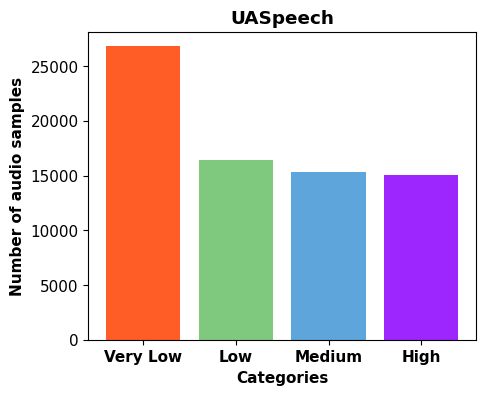

In [ ]:
import matplotlib.pyplot as plt

# Increase font size and set font weight to 'bold'
plt.rcParams.update({'font.size': 11})

class_labels = ['Very Low', 'Low', 'Medium', 'High']
values = list(label.value_counts())
colors = ['#ff5c26','#7fc97f', '#5da5db', '#9d26ff']

plt.figure(figsize=(5, 4))  # Adjusted figure size

# Use colors parameter to set colors for each bar
plt.bar(range(len(values)), values, color=colors)

plt.xlabel('Categories', fontweight='bold')  # Set font weight for xlabel
plt.ylabel('Number of audio samples', fontweight='bold')  # Set font weight for ylabel
plt.xticks(range(len(values)), class_labels, fontweight='bold')  # Set font weight for xticks

plt.title('UASpeech', fontweight='bold')  # Set font weight for title
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.2,random_state = 0)
len(X_train), len(X_test)

(58852, 14714)

## KNN


Train Accuracy: 0.9563

Test Metrics:
Precision: 0.9245
Recall: 0.9235
F1 Score: 0.9234
Accuracy: 0.9235

Classification Report:
              precision    recall  f1-score   support

           0      0.903     0.963     0.932      5390
           1      0.915     0.902     0.908      3006
           2      0.946     0.894     0.919      3058
           3      0.949     0.906     0.927      3260

    accuracy                          0.924     14714
   macro avg      0.928     0.916     0.922     14714
weighted avg      0.925     0.924     0.923     14714




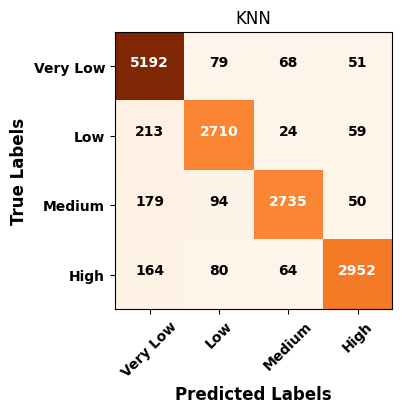

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "KNN")

## SVM Implementation


Train Accuracy: 0.9528

Test Metrics:
Precision: 0.9511
Recall: 0.9507
F1 Score: 0.9507
Accuracy: 0.9507

Classification Report:
              precision    recall  f1-score   support

           0      0.941     0.975     0.958      5390
           1      0.947     0.932     0.939      3006
           2      0.949     0.948     0.948      3058
           3      0.974     0.930     0.951      3260

    accuracy                          0.951     14714
   macro avg      0.953     0.946     0.949     14714
weighted avg      0.951     0.951     0.951     14714




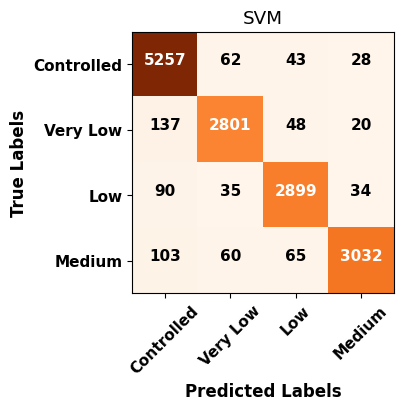

In [ ]:
from sklearn.svm import SVC
model = SVC(C=0.01, gamma=0.0001, kernel='poly')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "SVM")

## Decision Tree

Train Accuracy: 0.9697

Test Metrics:
Precision: 0.8545
Recall: 0.8546
F1 Score: 0.8544
Accuracy: 0.8546

Classification Report:
              precision    recall  f1-score   support

           0      0.861     0.887     0.874      5390
           1      0.822     0.800     0.811      3006
           2      0.850     0.849     0.849      3058
           3      0.878     0.857     0.867      3260

    accuracy                          0.855     14714
   macro avg      0.853     0.848     0.850     14714
weighted avg      0.855     0.855     0.854     14714




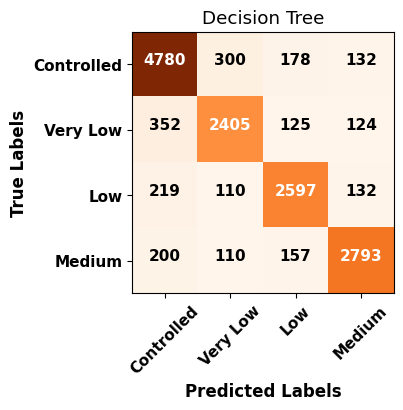

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", max_depth= 15)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "Decision Tree")

## Xg Boost

Train Accuracy: 0.9666

Test Metrics:
Precision: 0.9542
Recall: 0.9541
F1 Score: 0.9541
Accuracy: 0.9541

Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.971     0.962      5390
           1      0.944     0.944     0.944      3006
           2      0.953     0.946     0.949      3058
           3      0.965     0.944     0.954      3260

    accuracy                          0.954     14714
   macro avg      0.954     0.951     0.953     14714
weighted avg      0.954     0.954     0.954     14714




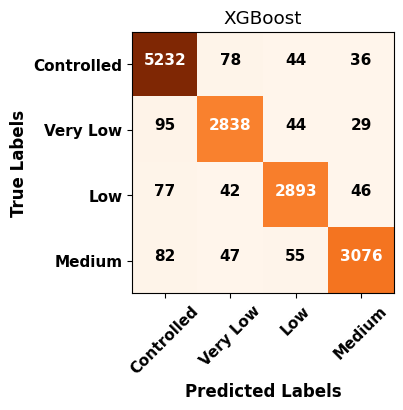

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
data_dmatrix

params = {
    'objective':'binary:logistic',
    'max_depth':4,
    'alpha':10,
    'learning_rate':1.0,
    'n_estimators':15
}

model = XGBClassifier(**params)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "XGBoost")

## Gradient Boosting

Train Accuracy: 0.7756

Test Metrics:
Precision: 0.8217
Recall: 0.7654
F1 Score: 0.7628
Accuracy: 0.7654

Classification Report:
              precision    recall  f1-score   support

           0      0.640     0.985     0.776      5390
           1      0.920     0.574     0.707      3006
           2      0.921     0.648     0.761      3058
           3      0.939     0.689     0.795      3260

    accuracy                          0.765     14714
   macro avg      0.855     0.724     0.760     14714
weighted avg      0.822     0.765     0.763     14714




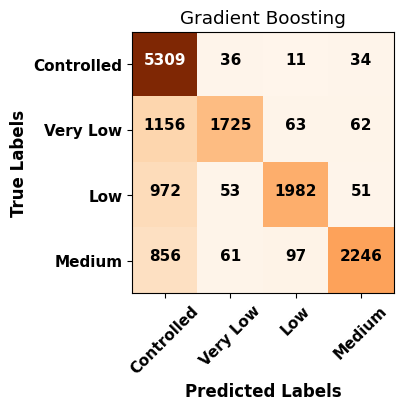

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=5)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "Gradient Boosting")


## Random Forest

Train Accuracy: 0.9999

Test Metrics:
Precision: 0.9608
Recall: 0.9599
F1 Score: 0.9599
Accuracy: 0.9599

Classification Report:
              precision    recall  f1-score   support

           0      0.935     0.989     0.961      5390
           1      0.970     0.938     0.954      3006
           2      0.972     0.954     0.963      3058
           3      0.984     0.938     0.961      3260

    accuracy                          0.960     14714
   macro avg      0.965     0.955     0.960     14714
weighted avg      0.961     0.960     0.960     14714




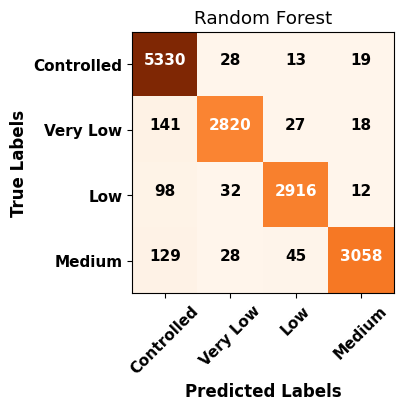

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=25,criterion = "entropy")
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_model(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, "Random Forest")

# Deep learning based models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2,random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

y_train_real = np.argmax(y_train, axis=1)
y_test_real = np.argmax(y_test, axis=1)

### ANN

In [ ]:
def build_model_ann():
    # Input layer with shape (batch_size, 193)
    inp1   = Input(shape=(None, 194))  # None for batch size dimension
    lay1   = Dense(units=512, activation='relu')(inp1)
    # lay2   = Dropout(0.4)(lay1)
    lay3   = Dense(units=256, activation='relu')(lay1)
    # lay4   = Dropout(0.2)(lay3)
    hidden1 = Dense(128, activation='relu')(lay3)
    # hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(4, activation='softmax')(hidden1)
    model   = Model(inputs=inp1, outputs=output)

    return model

In [ ]:
model = build_model_ann()

optimizer = SGD(learning_rate=0.0003, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
736/736 [==============================] - 21s 20ms/step - loss: 0.6573 - accuracy: 0.8120 - val_loss: 0.2379 - val_accuracy: 0.9160
Epoch 2/50
736/736 [==============================] - 10s 13ms/step - loss: 0.1984 - accuracy: 0.9320 - val_loss: 0.2630 - val_accuracy: 0.9022
Epoch 3/50
736/736 [==============================] - 6s 8ms/step - loss: 0.1364 - accuracy: 0.9525 - val_loss: 0.1055 - val_accuracy: 0.9637
Epoch 4/50
736/736 [==============================] - 8s 11ms/step - loss: 0.1058 - accuracy: 0.9630 - val_loss: 0.0743 - val_accuracy: 0.9753
Epoch 5/50
736/736 [==============================] - 6s 9ms/step - loss: 0.0914 - accuracy: 0.9685 - val_loss: 0.0777 - val_accuracy: 0.9729
Epoch 6/50
736/736 [==============================] - 9s 13ms/step - loss: 0.0799 - accuracy: 0.9719 - val_loss: 0.1105 - val_accuracy: 0.9600
Epoch 7/50
736/736 [==============================] - 6s 9ms/step - loss: 0.0690 - accuracy: 0.9759 - val_loss: 0.0933 - val_accuracy: 0.9676


Train Accuracy: 0.9959
Train Loss: 0.0119
Validation Accuracy: 0.9895
Validation Loss: 0.0340
460/460 [==============================] - 1s 2ms/step

Test Metrics:
Precision: 0.9917
Recall: 0.9916
F1 Score: 0.9916
Accuracy: 0.9916
Loss: 0.0277
              precision    recall  f1-score   support

           0      0.987     0.997     0.992      5390
           1      0.997     0.981     0.989      3006
           2      0.995     0.995     0.995      3058
           3      0.991     0.988     0.990      3260

    accuracy                          0.992     14714
   macro avg      0.993     0.991     0.992     14714
weighted avg      0.992     0.992     0.992     14714




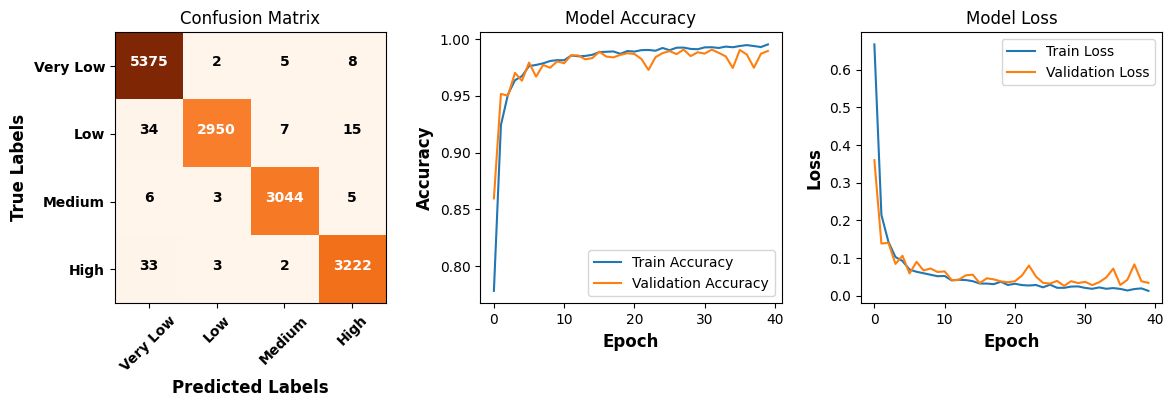

In [ ]:
# lstm 2
evaluate_model_nn(X_train, y_train, X_val, y_val, X_test, y_test, "", model, history)

Train Accuracy: 0.9972
Train Loss: 0.0069
Validation Accuracy: 0.9924
Validation Loss: 0.0237
460/460 [==============================] - 1s 2ms/step

Test Metrics:
Precision: 0.9940
Recall: 0.9940
F1 Score: 0.9939
Accuracy: 0.9940
Loss: 0.0185
              precision    recall  f1-score   support

           0      0.994     0.994     0.994      5390
           1      0.995     0.995     0.995      3006
           2      0.992     0.998     0.995      3058
           3      0.996     0.988     0.992      3260

    accuracy                          0.994     14714
   macro avg      0.994     0.994     0.994     14714
weighted avg      0.994     0.994     0.994     14714




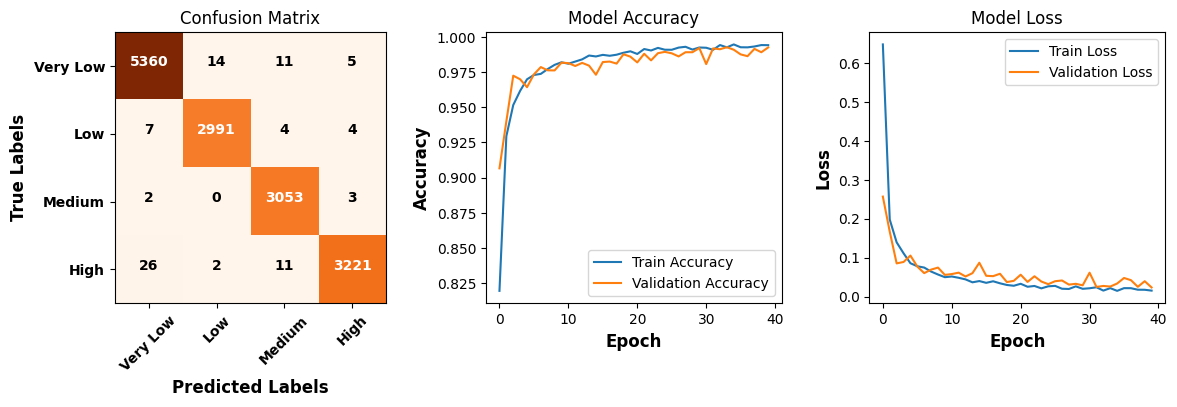

In [ ]:
evaluate_model_nn(X_train, y_train, X_val, y_val, X_test, y_test, "", model, history)


### CNN

In [ ]:
def build_model_cnn():

    inp   = Input(shape=194)
    lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp)
    lay2   = Dropout(0.4)(lay1)
    lay61  = Reshape((64,8,1))(lay2)
    lay62  = Conv2D(32, (3, 3), strides=(2, 2))(lay61)
    lay63  = AveragePooling2D((2, 2), strides=(2,2))(lay62)
    lay64  = BatchNormalization()(lay63)
    lay65  = Activation('relu')(lay64)

    lay66  = Conv2D(64, (3, 3), padding="same") (lay65)
    # lay67  = AveragePooling2D((2, 2), strides=(2,2)) (lay66)
    lay68  = BatchNormalization()(lay66)
    lay69  = Activation('relu')(lay68)

    lay611  = Conv2D(64, (3, 3), padding="same") (lay69)
    # lay612 = AveragePooling2D((2, 2), strides=(2,2)) (lay611)
    lay613 = BatchNormalization()(lay611)
    lay614 = Activation('relu')(lay613)

    lay615 = Flatten()(lay614)
    lay616 = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay615)
    lay617 = Dropout(rate=0.5)(lay616)
    lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
    lay4   = Dropout(0.2)(lay3)
    hidden1 = Dense(128, activation='relu')(lay4)
    hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(4, activation='softmax')(hidden2)
    model   = Model(inputs=inp, outputs=output)

    return model

In [ ]:
model_cnn = build_model_cnn()

optimizer = SGD(learning_rate=0.0003, momentum=0.9)
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
736/736 [==============================] - 16s 20ms/step - loss: 0.9437 - accuracy: 0.6478 - val_loss: 0.3993 - val_accuracy: 0.8667
Epoch 2/30
736/736 [==============================] - 14s 19ms/step - loss: 0.3729 - accuracy: 0.8693 - val_loss: 0.1685 - val_accuracy: 0.9442
Epoch 3/30
736/736 [==============================] - 14s 19ms/step - loss: 0.2603 - accuracy: 0.9103 - val_loss: 0.1445 - val_accuracy: 0.9528
Epoch 4/30
736/736 [==============================] - 7s 10ms/step - loss: 0.2069 - accuracy: 0.9287 - val_loss: 0.1225 - val_accuracy: 0.9603
Epoch 5/30
736/736 [==============================] - 8s 11ms/step - loss: 0.1813 - accuracy: 0.9383 - val_loss: 0.0958 - val_accuracy: 0.9674
Epoch 6/30
736/736 [==============================] - 6s 9ms/step - loss: 0.1611 - accuracy: 0.9452 - val_loss: 0.0754 - val_accuracy: 0.9741
Epoch 7/30
736/736 [==============================] - 9s 12ms/step - loss: 0.1430 - accuracy: 0.9511 - val_loss: 0.0920 - val_accuracy: 0.96

Train Accuracy: 0.9900
Train Loss: 0.0349
Validation Accuracy: 0.9846
Validation Loss: 0.0486
460/460 [==============================] - 1s 2ms/step

Test Metrics:
Precision: 0.9854
Recall: 0.9853
F1 Score: 0.9853
Accuracy: 0.9853
Loss: 0.0458
              precision    recall  f1-score   support

           0      0.994     0.978     0.986      5390
           1      0.985     0.985     0.985      3006
           2      0.991     0.991     0.991      3058
           3      0.967     0.992     0.979      3260

    accuracy                          0.985     14714
   macro avg      0.984     0.986     0.985     14714
weighted avg      0.985     0.985     0.985     14714




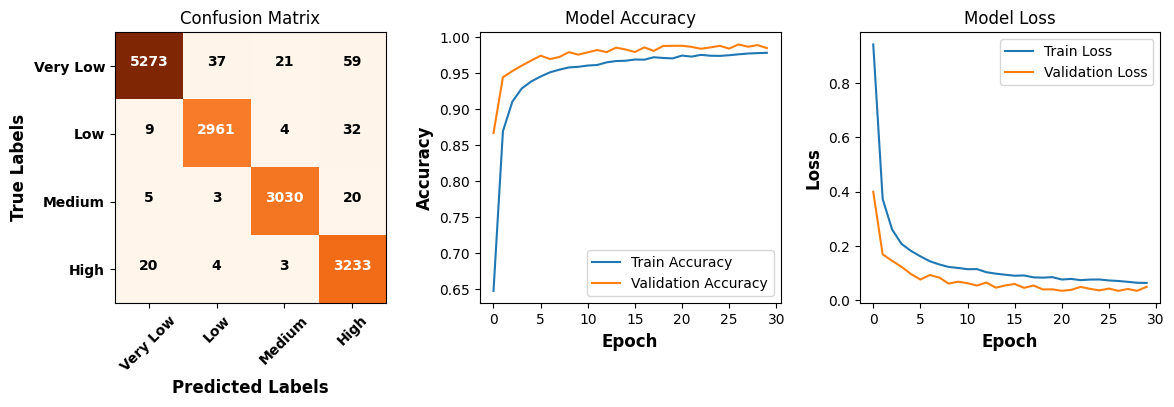

In [ ]:
# CNN 2

evaluate_model_nn(X_train, y_train, X_val, y_val, X_test, y_test, "", model_cnn, history)

Train Accuracy: 0.9904
Train Loss: 0.0291
Validation Accuracy: 0.9858
Validation Loss: 0.0389
460/460 [==============================] - 3s 5ms/step

Test Metrics:
Precision: 0.9879
Recall: 0.9878
F1 Score: 0.9878
Accuracy: 0.9878
Loss: 0.0376
              precision    recall  f1-score   support

           0      0.996     0.977     0.987      5390
           1      0.978     0.994     0.986      3006
           2      0.989     0.997     0.993      3058
           3      0.982     0.991     0.987      3260

    accuracy                          0.988     14714
   macro avg      0.986     0.990     0.988     14714
weighted avg      0.988     0.988     0.988     14714




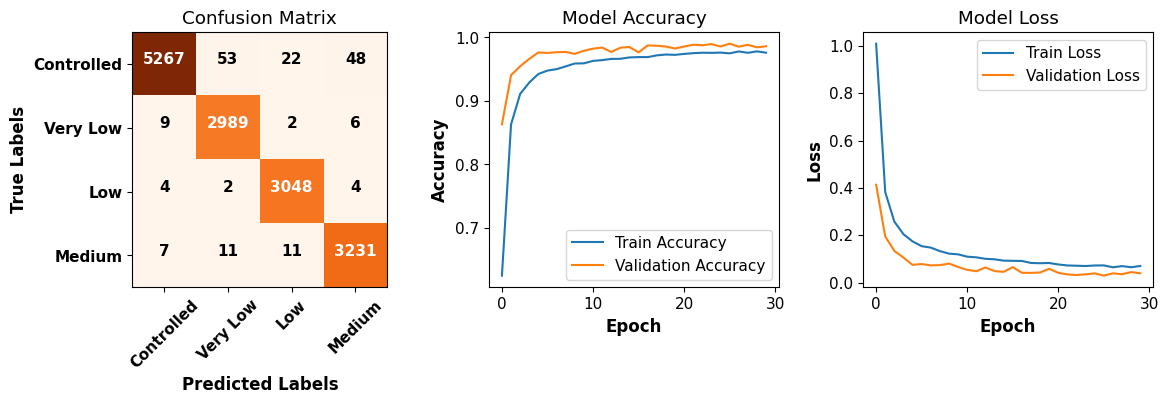

In [ ]:
evaluate_model_nn(X_train, y_train, X_val, y_val, X_test, y_test, "", model_cnn, history)

###LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, ConvLSTM1D, BatchNormalization, Flatten

def build_model_lstm():
    model = Sequential()

    # First block
    model.add(Dense(units=512, activation='relu', kernel_initializer='GlorotUniform', input_shape=(194,)))
    model.add(Dropout(0.3))

    # Second block
    model.add(Reshape((64, 8, 1)))
    model.add(ConvLSTM1D(filters=40, kernel_size=3, padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM1D(filters=40, kernel_size=3, padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu', kernel_initializer='GlorotUniform'))
    model.add(Dropout(rate=0.3))

    model.add(Dense(units=256, activation='relu', kernel_initializer='GlorotUniform'))
    model.add(Dropout(0.2))

    # model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(Dense(4, activation='softmax'))

    return model


In [ ]:
model_lstm = build_model_lstm()

optimizer = SGD(learning_rate=0.0003, momentum=0.9)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
736/736 [==============================] - 710s 950ms/step - loss: 1.1312 - accuracy: 0.5513 - val_loss: 0.9942 - val_accuracy: 0.6074
Epoch 2/50
736/736 [==============================] - 699s 950ms/step - loss: 0.6901 - accuracy: 0.7406 - val_loss: 0.7545 - val_accuracy: 0.6990
Epoch 3/50
736/736 [==============================] - 704s 956ms/step - loss: 0.4470 - accuracy: 0.8425 - val_loss: 0.8177 - val_accuracy: 0.6971
Epoch 4/50
736/736 [==============================] - 695s 945ms/step - loss: 0.3216 - accuracy: 0.8895 - val_loss: 0.9030 - val_accuracy: 0.6705
Epoch 5/50
736/736 [==============================] - 677s 919ms/step - loss: 0.2582 - accuracy: 0.9134 - val_loss: 0.6851 - val_accuracy: 0.7468
Epoch 6/50
736/736 [==============================] - 670s 910ms/step - loss: 0.2377 - accuracy: 0.9187 - val_loss: 0.5074 - val_accuracy: 0.8150
Epoch 7/50
736/736 [==============================] - 669s 909ms/step - loss: 0.2135 - accuracy: 0.9273 - val_loss: 0.5557 -

In [ ]:
evaluate_model_nn(X_train, y_train, X_val, y_val, X_test, y_test, "", model_lstm, history)

## KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9331249150468941

In [ ]:
y_pred = knn.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5390
           1       0.92      0.91      0.92      3006
           2       0.96      0.91      0.93      3058
           3       0.95      0.93      0.94      3260

    accuracy                           0.93     14714
   macro avg       0.94      0.93      0.93     14714
weighted avg       0.93      0.93      0.93     14714



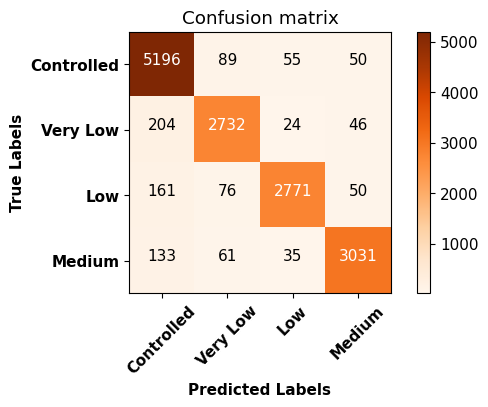

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test)
classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"
# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')


## SVM Implementation


In [ ]:
from sklearn.svm import SVC
model = SVC(C=0.1, gamma=0.001, kernel='poly')

In [ ]:
model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.001, kernel='poly')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_test, y_pred))

0.9881745276607313


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



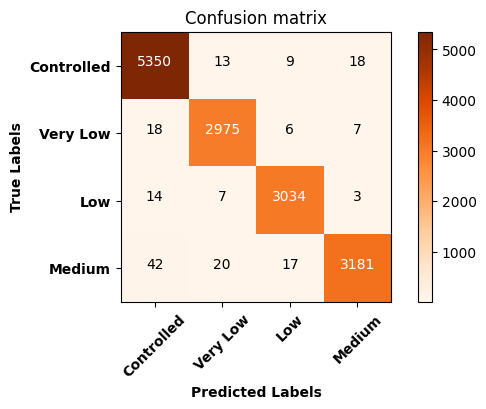

In [ ]:
# importing the required modules
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"
# passing actual and predicted values`
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5390
           1       0.99      0.99      0.99      3006
           2       0.99      0.99      0.99      3058
           3       0.99      0.98      0.98      3260

    accuracy                           0.99     14714
   macro avg       0.99      0.99      0.99     14714
weighted avg       0.99      0.99      0.99     14714



##Tune Parameters


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, grid_predictions))

0.9626774847870182


## Xg Boost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
data_dmatrix

params = {
    'objective':'binary:logistic',
    'max_depth':4,
    'alpha':10,
    'learning_rate':1.0,
    'n_estimators':100
}

model = XGBClassifier(**params)

model.fit(X_train,y_train)


XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9883784151148566


In [ ]:
print(classification_report(y_test,y_pred,digits=4))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5390
           1       0.99      0.98      0.99      3006
           2       0.99      0.99      0.99      3058
           3       0.99      0.98      0.99      3260

    accuracy                           0.99     14714
   macro avg       0.99      0.99      0.99     14714
weighted avg       0.99      0.99      0.99     14714



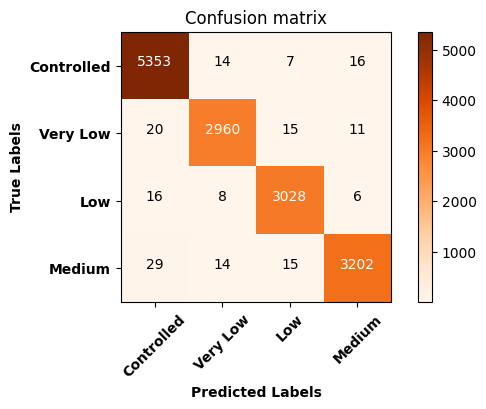

In [ ]:
classes = ["Controlled","Very Low", "Low", "Medium"]
name = "Confusion matrix"

y_pred = model.predict(X_test)
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')


## Gradient Boosting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
X_train,X_test,y_train,y_test=train_test_split(features,label,test_size=0.3,random_state=101)

from sklearn.ensemble import GradientBoostingClassifier

model  = GradientBoostingClassifier()
model.fit(X_train,y_train)
model.score(X_test,y_test)

# from sklearn.model_selection import GridSearchCV
# param={'n_estimators':(5,10,20,40,60,80,100,120,140,160,180),'learning_rate':(0.1,0.2,0.4,0.8,1.0,1.2,1.6)}
# grid=GridSearchCV( GradientBoostingClassifier(),param,cv=10,error_score='raise')
# grid.fit(X_test,y_test)
# print(grid.best_estimator_)

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test)
classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"
# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
model.fit(X_train, y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score

# printing the accuracy of the model
print(accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

In [ ]:
# importing the required modules
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=201,criterion = "entropy")
model.fit(X_train, y_train)

In [ ]:
model.score(X_test,y_test)

In [ ]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"

# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
features_pca = pca.fit_transform(features)

In [ ]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(features_pca, label, test_size=0.3)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

0.9249492900608519

In [ ]:
from sklearn.svm import SVC
model = SVC(C=0.1, gamma=0.001, kernel='poly')
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.9456389452332657

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=201,criterion = "entropy")
model.fit(X_train_pca, y_train)
model.score(X_test_pca,y_test)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test_pca)
classes = ["Controlled", "Very Low", "Low", "Medium"]
name = "Confusion matrix"
# passing actual and predicted values
create_confusion_matrix(classes, name = name, y_true = y_test[:len(y_pred)], y_pred = y_pred, map_col = 'Oranges')

# Deep Learning

In [ ]:
def build_model():
    # Input layer with shape (batch_size, 193)
    inp1   = Input(shape=(None, 194))  # None for batch size dimension
    lay1   = Dense(units=512, activation='relu')(inp1)
    # lay2   = Dropout(0.4)(lay1)
    lay3   = Dense(units=256, activation='relu')(lay1)
    # lay4   = Dropout(0.2)(lay3)
    hidden1 = Dense(128, activation='relu')(lay3)
    # hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(4, activation='softmax')(hidden1)
    model   = Model(inputs=inp1, outputs=output)

    return model

In [ ]:
from keras.layers import Input, Dense, Dropout, Reshape, ConvLSTM1D, BatchNormalization, Flatten


def build_model():
    '''Function to build ensemble model'''
    # First Model
    input_layer = Input(shape=(194,))
    x = Dense(units=512, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    x = Dropout(0.4)(x)
    x = Reshape((64, 8, 1))(x)
    x = Conv2D(32, (3, 3), strides=(2, 2))(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(rate=0.5)(x)

    x = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [ ]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.2,random_state = 0)

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)


# Build the model
model = build_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val))

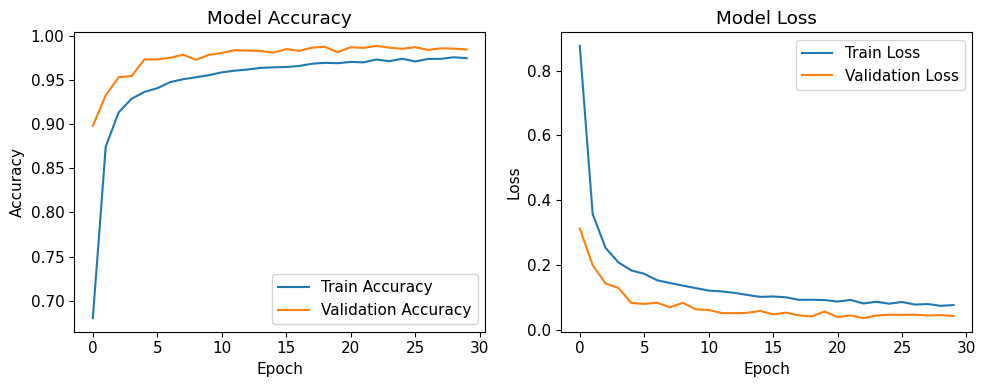

In [ ]:
# Plot history for accuracy and loss
plt.figure(figsize=(10, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from keras.layers import Input, Dense, Dropout, Reshape, Conv2D, AveragePooling2D, BatchNormalization, Activation, Flatten
from keras.models import Model

def build_model():
    '''Function to build ensemble model'''
    # First Model
    input_layer = Input(shape=(193,))
    x = Dense(units=512, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    x = Dropout(0.4)(x)
    x = Reshape((64, 8, 1))(x)
    x = Conv2D(32, (3, 3), strides=(2, 2))(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(rate=0.5)(x)

    x = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)

    return model


In [ ]:
from keras.layers import Input, Dense, Dropout, Reshape, ConvLSTM1D, BatchNormalization, Flatten
from keras.models import Model

def build_model():
    '''Function to build ensemble model'''
    # Input Layer
    input_layer = Input(shape=(193,))

    # First Dense Block
    x = Dense(units=512, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    x = Dropout(0.4)(x)

    # Reshape Layer
    x = Reshape((64, 8, 1))(x)

    # ConvLSTM Block
    x = ConvLSTM1D(filters=40, kernel_size=3, padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)

    # Another ConvLSTM Block
    x = ConvLSTM1D(filters=40, kernel_size=3, padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)

    # Flatten Layer
    x = Flatten()(x)

    # Dense Layers
    x = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(rate=0.5)(x)

    # Second Dense Block
    y = Dense(units=256, activation='relu', kernel_initializer='glorot_uniform')(input_layer)
    y = Dropout(0.2)(y)
    y = Dense(128, activation='relu')(y)

    # Final Dense Layers
    hidden1 = Dense(128, activation='relu')(x)
    hidden2 = Dense(64, activation='relu')(hidden1)

    # Output Layer
    output = Dense(4, activation='softmax')(hidden2)

    # Model
    model = Model(inputs=input_layer, outputs=output)

    return model
